In [129]:
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import prince
import scipy.stats as stats


import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

sys.path.insert(0, '..')
sys.path.insert(0, '../..')


import sparql_functions as spqf

In [54]:
endpoint = "https://ag1zhv7l0xefmdtk.allegrograph.cloud/repositories/Esport"

query = """
PREFIX wd:      <http://www.wikidata.org/entity/>
PREFIX wdt:     <http://www.wikidata.org/prop/direct/>
PREFIX rdfs:    <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>


SELECT  ?item 
        (SAMPLE(STR(?itemLabel)) as ?itemLabel) 
        (MAX(?birthDate) as ?birthDate)  
        (MAX(?country) as ?country)
        ( GROUP_CONCAT(DISTINCT ?game; separator=", ") AS ?games )
WHERE {
    GRAPH <https://github.com/enaxorb/esportplayers/blob/main/graphs/wikidata-imported-data.md> {        
    ?item wdt:P569 ?birthDate;
        wdt:P27 ?country;
        wdt:P2416 ?game;

    OPTIONAL {?item rdfs:label ?itemLabel .}
  }  
}
GROUP BY ?item
"""

In [55]:
qr = spqf.get_json_sparql_result(endpoint,query)
r = [l for l in spqf.sparql_result_to_list(qr)]

In [56]:
dfc = pd.DataFrame(r)
dfc.columns = ['personUri','itemLabel','birthYear','country','game']

In [101]:
#Nettoyage
def clean_id(s):
    if isinstance(s,str) and s.startswith('http'):
        return s.rsplit('/', 1) [-1]
    return s
dfc['country_clean'] = dfc['country'].apply(clean_id)

def clean_id(s):
    if isinstance(s,str) and s.startswith('http'):
        return s.rsplit('/', 1) [-1]
    return s
dfc['game_clean'] = dfc['game'].apply(clean_id)

dfc['country_list']=dfc['country_clean'].apply(clean_id)
edges_player_game = (
    dfc[['itemLabel', 'country_list']]
      .explode('country_list') 
)

player_pgc = (
    edges_player_game.groupby('country_list')['itemLabel']
    .nunique()
    .sort_values(ascending=False)
)

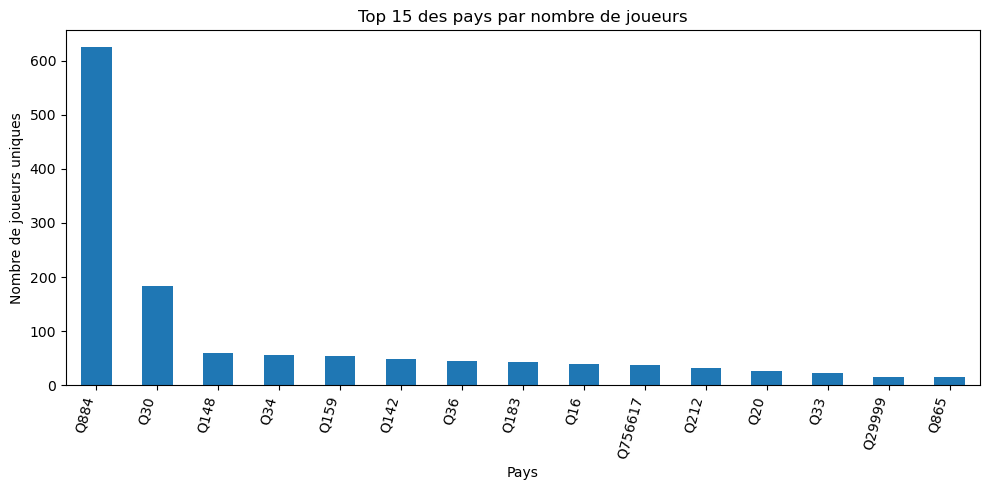

In [102]:
top15 = player_pgc.head(15)

plt.figure(figsize=(10,5))
top15.plot(kind='bar')
plt.ylabel("Nombre de joueurs uniques")
plt.xlabel("Pays")
plt.title("Top 15 des pays par nombre de joueurs")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

In [103]:
#Tableau de contingence
tab_cont = pd.crosstab(dfc['country_clean'], dfc['game_clean'])

game_clean     Q104830848  Q1052131  Q107247149  Q107424191  Q108054772  \
country_clean                                                             
Q1028                   0         0           0           0           0   
Q1054923                0         0           0           0           0   
Q1246                   0         0           0           0           0   
Q142                    1         1           0           0           0   
Q145                    0         0           0           0           0   

game_clean     Q10896671  Q111165107  Q112674290  Q11339103  Q1195150  ...  \
country_clean                                                          ...   
Q1028                  0           0           0          0         0  ...   
Q1054923               0           0           0          0         0  ...   
Q1246                  0           1           0          0         0  ...   
Q142                   0           0           0          0         1  ...   
Q145  

In [105]:
#chicarré
chi2, p, dof, expected = chi2_contingency(tab_cont)
if p < 0.05:
    print("dépendance significative")
else:
    print("Pas de dépendance")

dépendance significative


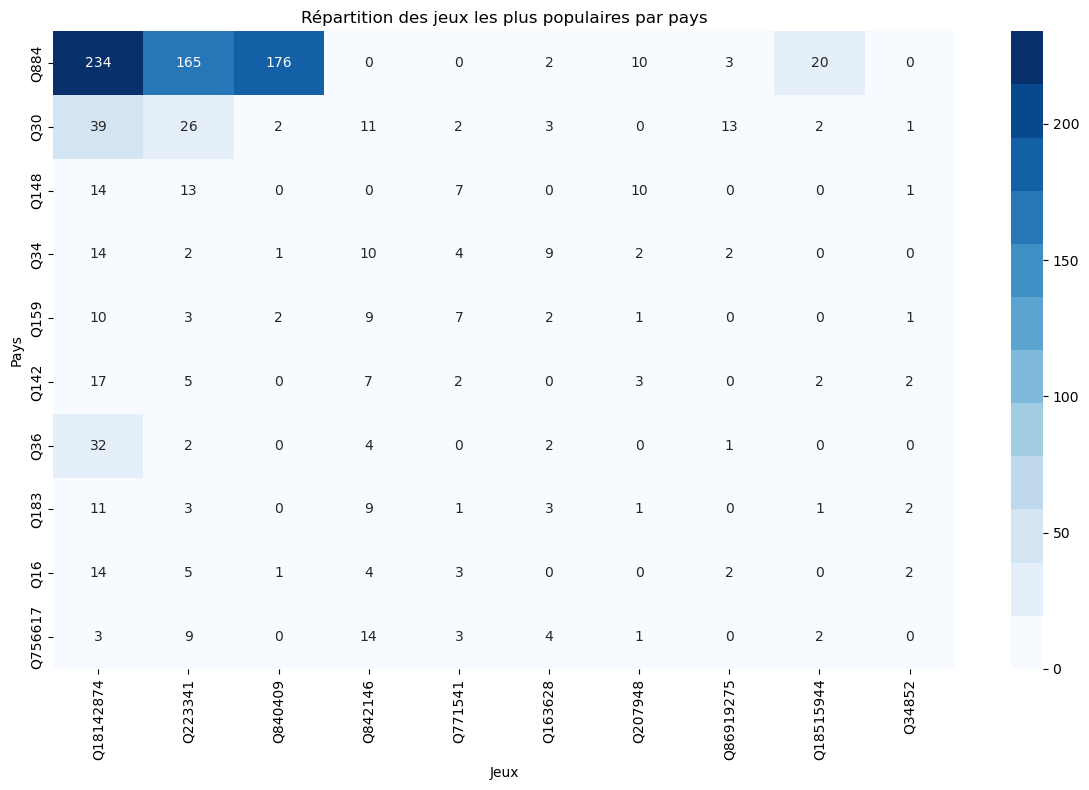

In [146]:
#Visualisation
top_countries = dfc['country_clean'].value_counts().head(10).index
top_games = dfc['game_clean'].value_counts().head(10).index
tab_filtered = tab_cont.loc[top_countries, top_games]

plt.figure(figsize=(12,8))
sns.heatmap(tab_filtered, annot = True, cmap = cmap, fmt="d"
)
plt.title("Répartition des jeux les plus populaires par pays")
plt.xlabel("Jeux")
plt.ylabel("Pays")
plt.tight_layout()
plt.show()